In [9]:
!unzip /content/word_dataset_new_mar20.zip

Archive:  /content/word_dataset_new_mar20.zip
replace word_dataset_new_mar20/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Train the model
=====

Now we will see how to train the model that recognizes the word in images.

First, we will import needed functions from py file.

In [10]:
'''
import os
from keras import utils
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
'''
from word_recognition_model import *






# Strategy for Model

Our strategy is to load dataset we got (IAM_words), which is made of images of the words and the labels of them.
Then, we will resize the images, divide them into multiple batches, and train the model.

# Take a look at dataset

Let's print few examples of dataset, images and the labels of them.

/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-00.png => We


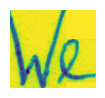

/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-01.png => know


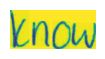

/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-02.png => from


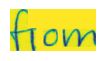

/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-03.png => the


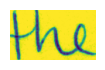

/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-04.png => diaries


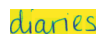

'\n- **Reads each line** of your labels file and skips comments.\n- Extracts the relevant information from each line.\n- Constructs the correct image path based on your described directory structure.\n- Associates each path correctly with its label.\n\nThis resulting list of paths and labels can now easily feed into TensorFlow or other ML pipelines.\n'

In [12]:
# Example usage
label_file = '/content/word_dataset_new_mar20/words.txt'
image_paths, labels = parse_labels(label_file)


# Let's print a few examples
for path, label in zip(image_paths[:5], labels[:5]):
    print(f"{path} => {label}")
    img = mpimg.imread(path)

    i = 1
    ax = plt.subplot(1,5,i)
    i += 1

    plt.imshow(img)
    plt.axis('off')
    plt.show()


# image_paths and labels are ready to be used in your training pipeline


### **Explanation:**
"""
- **Reads each line** of your labels file and skips comments.
- Extracts the relevant information from each line.
- Constructs the correct image path based on your described directory structure.
- Associates each path correctly with its label.

This resulting list of paths and labels can now easily feed into TensorFlow or other ML pipelines.
"""

# Vectorization

We will develop a way to convert alphabetical words into numerical representation of them, for easier calculation.
The words will be represented as vectors of numbers.

The char_to_num will convert characters into numbers, and num_to_char will do the inverse of it.

In [13]:

# Create a set of unique characters
characters = sorted(set(''.join(labels)))


# Proper definition: need to make 0 a padding character, not normal character
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=characters,
    num_oov_indices=1,
    mask_token=None,  # explicitly reserve 0 for padding/blank
)

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    num_oov_indices=1,
    mask_token=None
)

# Ensure blank token is correctly mapped
blank_index = len(char_to_num.get_vocabulary())  # Last index is blank
print(f"Blank token index: {blank_index}")

Blank token index: 71


In [14]:
print(characters)

['!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [15]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 300  # Unifying size of images - Why 64, 300?
# Average length of english word is 4.7 characters (Googled)
# Assuming a character is square, it means word width is 4.7 times word height
# 64*4.7 = 300

# maybe split the image into single characters?
# ML models only accept unified dimensions



This is an example of how vectorization works, as you see word "We" is represented as tensor of 43, 49.

tf.Tensor([43 49], shape=(2,), dtype=int64) <StringLookup name=string_lookup_2, built=True>


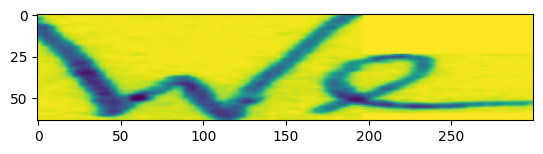

In [16]:
def encode_label(label):
    label_chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label_encoded = char_to_num(label_chars)
    return label_encoded


# Testing load_and_preprocess_image and encode_label functions
# Should print processed image and numerical tensor-representation of word label
plt.imshow(load_and_preprocess_image(image_paths[0]))
print(encode_label(labels[0]), char_to_num)

# Pre-processing the dataset

Then, we will prepare dataset by processing images, such as unifying the dimensions of images and converting them into grayscale.
It also includes process of vectorizing the label words.
Then, the dataset is prepared by using the preprocess_dataset, which does all the things mentioned above.

In [18]:
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))


def preprocess_dataset(image_path, label):
    image = load_and_preprocess_image(image_path)
    label = encode_label(label)
    return ({"image": image}, label)


# Apply padding during batching
dataset = dataset.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.padded_batch(
    BATCH_SIZE,
    padded_shapes=(
        {"image": [IMAGE_HEIGHT, IMAGE_WIDTH, 1]},
        [None]
    ),
    padding_values=(
        {"image": 0.0},
        np.int64(0)
    )
).prefetch(tf.data.AUTOTUNE)




In [19]:
# Get dataset size to confirm dataset is well established
size = dataset.cardinality().numpy()
print("Dataset size:", size)


Dataset size: 182


# Build model

The most important part--Model--is built using CNN and RNN layers.
CNN is used to extract the features of images, and RNN is used to decode the sequence of characters- since it's best at recognizing patterns of sequences.
The RNN layers use LSTM, which is passed to dense output.

The goal of the model is to minimize the CTC loss, which is special loss function for OCR.
The CTC returns probabilities of each characters in the image, which is used to "build" words off of predicted characters.

In [20]:
input_img = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='image')

# CNN layers
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

# Prepare data for RNN
new_shape = (IMAGE_WIDTH // 4, (IMAGE_HEIGHT // 4) * 64)
x = tf.keras.layers.Reshape(target_shape=new_shape)(x)

# RNN layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

# Output layer
output = tf.keras.layers.Dense(len(characters) + 2, activation='softmax')(x)

model = tf.keras.Model(inputs=input_img, outputs=output)

model.compile(optimizer='adam', loss=ctc_loss)


# Training

We will train the model.
It is found that around 40 epochs lead to best result, with CTC loss of around 2.
10 epoch is used in notebook for training demonstration.

In [21]:
EPOCHS = 10

model.fit(dataset, epochs=EPOCHS)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(None, 64, 300, 1))']
  warnings.warn(msg)


182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 45.3523
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 18.2344
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 17.7731
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 17.3574
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 17.0125
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 16.6352
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 16.2679
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 15.9318
Epoch 9/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 15.6318
Epoch 10/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 15.3502


# Using the model

Finally, we will try to use the model to recognize words in images.

The predict_text function will get the input image, and use the model to get vector result of predicted word.
Then the decode_ctc will convert the numeric vector into word, using num_to_char function.

The result of predict_text is displayed below.
It has problem of empty space displayed as UNK, but we will fiter those out in final dash webapp.

In [22]:
def decode_ctc(predicted_indices):
    chars = num_to_char(predicted_indices)

    # Convert tensor to string
    decoded_text = tf.strings.reduce_join(chars, axis=-1)
    decoded_text = decoded_text.numpy()[0].decode('utf-8')

    # Remove '[UNK]' and blank characters
    final_text = []
    prev_char = ''
    for char in decoded_text:
        if char not in ['[UNK]', '', ' '] and char != prev_char:  # Ignore blanks
            final_text.append(char)
            prev_char = char

    return ''.join(final_text)


def predict_text(model, image_path):
    img_tensor = preprocess_single_image(image_path)
    prediction = model.predict(img_tensor)

    # Convert to character indices
    predicted_indices = tf.argmax(prediction, axis=-1)

    print("Predicted indices:", predicted_indices.numpy())  # Debug print

    return decode_ctc(predicted_indices)


# Example Usage:
image_path = '/content/word_dataset_new_mar20/words/e01/e01-014/e01-014-00-00.png'
predicted_word = predict_text(model, image_path)
print(f"The image says: {predicted_word}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Predicted indices: [[64 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71
  71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71
  71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71 71
  71 71 71]]
The image says: t[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]
